In [1]:
!pip install tfimm
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.9/225.9 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.7 MB/s eta 0:00:00


In [2]:
pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 2.7 MB/s eta 0:00:00


In [4]:
!pip install tensorflow_probability==0.20.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 17.2 MB/s eta 0:00:00
Reason for being yanked: TFP 0.20 should require Python 3.8+
  Attempting uninstall: tensorflow_probability
    Found existing installation: tensorflow-probability 0.22.0
    Uninstalling tensorflow-probability-0.22.0:
      Successfully uninstalled tensorflow-probability-0.22.0


In [5]:
import math, re, os
import random
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
import tfimm
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from tensorflow import keras
from functools import partial
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import Model
print("Tensorflow version " + tf.__version__)
from sklearn.metrics import accuracy_score
from collections import Counter


Tensorflow version 2.12.0


In [6]:
!pip install huggingface_hub

In [7]:
import tensorflow_addons as tfa


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

In [8]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_bfloat16')

# CONNECT TO TPU


In [9]:


try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    DEVICE = "TPU"
except:
    DEVICE = "notTPU"
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)



Device: grpc://10.49.32.226:8470


Number of replicas: 8


# Parameters

In [10]:
class Config(object):
  def __init__(self):
    self.smoothing = 0.0
    self.model_name = "convnext_large_in22k"  #  "convnext_xlarge_in22k"
    self.folder = f"drive/My Drive/Cassava/{self.model_name}-mixup-cutmix"
    self.num_class = 5
    self.epochs = 150
    self.kfold = 5
    self.seed = 42
    self.verbose = True
    self.resize = (600, 600) #(600, 800)
    self.crop_size = (580,580)
    self.rotation = 30
    self.shear = 0.02
    self.zoom = 0.025# 0.05
    self.h_shift = 0.05
    self.w_shift = 0.05
    self.mixup = True
    self.cutmix = True
    self.l_mixup = 1.0
    self.cutout = True
    self.cutout_max = 10

cfg = Config()
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH ='gs://kds-c223954ffd3b57dd15f1aa543b304417f4c5a9110f21f2eaa0990f6b' # put gs link from kaggle GCS_PATH = KaggleDatasets().get_gcs_path("cassava-tfrecord-stratified")
GCS_PATH2 ='gs://kds-d70530dcb0d14e93a875771b3b7dbb1b0a96ebcecf0d5ed460e3eec4'
SHUFFLE = 512
FILENAMES = list(sorted(tf.io.gfile.glob(GCS_PATH + '/ld_train*.tfrec')))

REPLICAS =  strategy.num_replicas_in_sync
BATCH_SIZE0 = 8
BATCH_SIZE = BATCH_SIZE0 * strategy.num_replicas_in_sync
IMAGE_SIZE = [600, 800]#list(cfg.resize)
IMG_DIM = IMAGE_SIZE
EXT = list(sorted(tf.io.gfile.glob(GCS_PATH2 + '/ld_ext_*.tfrec')))
AUGMENT = {}

In [11]:
import os
if not os.path.exists(cfg.folder):
    os.makedirs(cfg.folder)

In [12]:
print(FILENAMES)

['gs://kds-c223954ffd3b57dd15f1aa543b304417f4c5a9110f21f2eaa0990f6b/ld_train00-2140.tfrec', 'gs://kds-c223954ffd3b57dd15f1aa543b304417f4c5a9110f21f2eaa0990f6b/ld_train01-2140.tfrec', 'gs://kds-c223954ffd3b57dd15f1aa543b304417f4c5a9110f21f2eaa0990f6b/ld_train02-2140.tfrec', 'gs://kds-c223954ffd3b57dd15f1aa543b304417f4c5a9110f21f2eaa0990f6b/ld_train03-2140.tfrec', 'gs://kds-c223954ffd3b57dd15f1aa543b304417f4c5a9110f21f2eaa0990f6b/ld_train04-2140.tfrec', 'gs://kds-c223954ffd3b57dd15f1aa543b304417f4c5a9110f21f2eaa0990f6b/ld_train05-2140.tfrec', 'gs://kds-c223954ffd3b57dd15f1aa543b304417f4c5a9110f21f2eaa0990f6b/ld_train06-2140.tfrec', 'gs://kds-c223954ffd3b57dd15f1aa543b304417f4c5a9110f21f2eaa0990f6b/ld_train07-2139.tfrec', 'gs://kds-c223954ffd3b57dd15f1aa543b304417f4c5a9110f21f2eaa0990f6b/ld_train08-2139.tfrec', 'gs://kds-c223954ffd3b57dd15f1aa543b304417f4c5a9110f21f2eaa0990f6b/ld_train09-2139.tfrec']


# Load Data

In [13]:
def read_tfrecord(example, labeled, return_image_name=False):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        if return_image_name:
            return image, tf.reshape(tf.one_hot([label], depth=cfg.num_class , axis=-1), [-1]), example["image_name"]
        return image, tf.reshape(tf.one_hot([label], depth=cfg.num_class , axis=-1), [-1])
    idnum = example['image_name']
    return image, idnum

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

In [14]:
def load_dataset(filenames, labeled=True, ordered=False, return_image_name=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled, return_image_name=return_image_name), num_parallel_calls=AUTOTUNE)
    return dataset

## augmentation

In [21]:
def zoom_out(x, scale_factor):

    resize_x = tf.random.uniform(shape=[], minval=tf.cast(IMG_DIM[1]//(1/scale_factor), tf.int32), maxval=IMG_DIM[1], dtype=tf.int32)
    resize_y = tf.random.uniform(shape=[], minval=tf.cast(IMG_DIM[0]//(1/scale_factor), tf.int32), maxval=IMG_DIM[0], dtype=tf.int32)
    top_pad = (IMG_DIM[0] - resize_y) // 2
    bottom_pad = IMG_DIM[0] - resize_y - top_pad
    left_pad = (IMG_DIM[1] - resize_x ) // 2
    right_pad = IMG_DIM[1] - resize_x - left_pad

    x = tf.image.resize(x, (resize_y, resize_x))
    x = tf.pad([x], [[0,0], [top_pad, bottom_pad], [left_pad, right_pad], [0,0]])
    x = tf.image.resize(x, IMG_DIM)
    return tf.squeeze(x, axis=0)

def zoom_in(x, scale_factor):

    scales = list(np.arange(0.5, 1.0, 0.05))
    boxes = np.zeros((len(scales),4))

    for i, scale in enumerate(scales):
        x_min = y_min = 0.5 - (0.5*scale)
        x_max = y_max = 0.5 + (0.5*scale)
        boxes[i] = [x_min, y_min, x_max, y_max]

    def random_crop(x):
        crop = tf.image.crop_and_resize([x], boxes=boxes, box_indices=np.zeros(len(boxes)), crop_size=IMG_DIM)
        return crop[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    return random_crop(x)

def zoom_aug(image, scale, p=0.5):
    if scale > 0 and tf.random.uniform(shape=[], minval=0.0, maxval=1.0) < p:
        if tf.random.uniform(shape=[], minval=0.0, maxval=1.0) > 0.5:
            image = zoom_in(image, scale)
        else:
            image = zoom_out(image, scale)
    return image

In [22]:
# Image shape : Height Width
def tf_rotate(img, rotation, p=0.5):
    if rotation > 0 and  tf.random.uniform(shape=[], minval=0.0, maxval=1.0) < p:
        angle = tf.random.uniform(shape=[], minval=-rotation, maxval=rotation, dtype=tf.float32)
        angle = angle * tf.constant(np.pi/180) # deg2rad
        img = tfa.image.rotate(img, angle)
    return img

def tf_shift(img, v, p=0.5):
    if (v[0] > 0 or v[1] > 0) and tf.random.uniform(shape=[], minval=0.0, maxval=1.0) < p:
        tx = tf.random.uniform(shape=[], minval=-v[0], maxval=v[0], dtype=tf.float32)
        ty = tf.random.uniform(shape=[], minval=-v[1], maxval=v[1], dtype=tf.float32)
        tx = tx * IMAGE_SIZE[1] # width
        ty = ty * IMAGE_SIZE[0] # height
        img = tfa.image.translate(img, [tx, ty])
    return img
def tf_shear(img, v, p=0.5):
    if v>0 and tf.random.uniform(shape=[], minval=0.0, maxval=1.0) < p:
        shearx = tf.random.uniform(shape=[], minval=0.0, maxval=v, dtype=tf.float32)
        img = tfa.image.shear_x(img, shearx, replace=0)
        img = tfa.image.shear_y(img, shearx, replace=0)
    return img

def tf_cutout(img, cfg, p=0.5):
    if tf.random.uniform(shape=[], minval=0.0, maxval=1.0) < p:
      for i in range(tf.random.uniform(shape=[], minval=1, maxval=cfg.cutout_max, dtype=tf.dtypes.int32)):
          mask = tf.random.uniform(shape=[], minval=10, maxval=30, dtype=tf.dtypes.int32)
          img = tfa.image.random_cutout(images=img, mask_size=(mask, mask))
    return img

def tf_gaussian_blur(img, p=0.5):
  if tf.random.uniform(shape=[], minval=0.0, maxval=1.0) < p:
    img = tfa.image.gaussian_filter2d(img)
  return img

def tf_augment(img, cfg):

    img = zoom_aug(img, scale=cfg.zoom, p=0.25)
    img = tf_rotate(img, cfg.rotation, p=0.25)
    img = tf_shift(img, (cfg.w_shift, cfg.h_shift), p=0.25)
    img = tf_shear(img, cfg.shear, p=0.25)


    return img

In [23]:
def data_augment(img, label):
    # Thanks to the dataset.prefetch(AUTO) statement in the following function this happens essentially for free on TPU.
    # Data pipeline code is executed on the "CPU" part of the TPU while the TPU itself is computing gradients.
    global cfg


    img = tf_augment(img, cfg)
    #img = tf.image.random_crop(img, [cfg['crop_size'][0], cfg['crop_size'][1], 3])

    img = tf.image.random_flip_left_right(img)


    #img = tf.image.random_hue(img, 0.025)
    #img = tf.image.random_saturation(img, 0.9, 1.1)
    #img = tf.image.random_contrast(img, 0.9, 1.1)
    #img = tf.image.random_brightness(img, 0.015)

    #img = tf.clip_by_value(img, clip_value_min=0.0, clip_value_max=1.0)
    img = tf.image.resize(img, [cfg.resize[0], cfg.resize[1]] )

    return img, label

def data_augment_batch(img, label):
    # Thanks to the dataset.prefetch(AUTO) statement in the following function this happens essentially for free on TPU.
    # Data pipeline code is executed on the "CPU" part of the TPU while the TPU itself is computing gradients.
    global cfg

    if cfg.cutout:
      img = tf_cutout(img, cfg, p=0.3)
    #img = tf_gaussian_blur(img, p=0.25)
    #img = tf.clip_by_value(img, clip_value_min=0.0, clip_value_max=1.0)
    return img, label




def data_resize_val(img, label ):
    # Thanks to the dataset.prefetch(AUTO) statement in the following function this happens essentially for free on TPU.
    # Data pipeline code is executed on the "CPU" part of the TPU while the TPU itself is computing gradients.
    global cfg


    #img = tf_augment(img, cfg)
    #img = tf.image.random_crop(img, [cfg['crop_size'][0], cfg['crop_size'][1], 3])

    #img = tf.image.random_flip_left_right(img)


    #img = tf.image.random_hue(img, 0.025)
    #img = tf.image.random_saturation(img, 0.9, 1.1)
    #img = tf.image.random_contrast(img, 0.9, 1.1)
    #img = tf.image.random_brightness(img, 0.015)

    #img = tf.clip_by_value(img, clip_value_min=0.0, clip_value_max=1.0)
    img = tf.image.resize(img, [cfg.resize[0], cfg.resize[1]] )
    return img, label

In [24]:
def tf_mixup(images, one_hot_labels):
        #one_hot_labels = np.eye(cfg["num_class"])[labels]  # one hot coding
        #print(images.shape, one_hot_labels.shape)
        # mixup implementation:
        # Note that for larger images, it's more efficient to do mixup on GPUs (i.e. in the graph)
        weight = tf.random.uniform(shape=(BATCH_SIZE, ), minval=0.2, maxval=0.8) # beta_dist.sample(BATCH_SIZE) #
        x_weight = tf.reshape(weight, (BATCH_SIZE, 1, 1, 1))
        y_weight = tf.reshape(weight, (BATCH_SIZE, 1))
        index = tf.random.shuffle(tf.range(0, BATCH_SIZE, dtype=tf.int32))#np.random.permutation(BATCH_SIZE)

        x1, x2 = images, tf.gather(images, index)
        x = x1 * x_weight + x2 * (1 - x_weight)
        y1, y2 = one_hot_labels, tf.gather(one_hot_labels, index)
        y = y1 * y_weight + y2 * (1 - y_weight)
        return x, y

def tf_cutmix(image, label, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    global cfg
    DIM = cfg.resize[0] #IMAGE_SIZE[0] #y
    DIM2 = cfg.resize[1] #IMAGE_SIZE[1] # x
    AUG_BATCH = BATCH_SIZE

    imgs = []; labs = []
    for j in range(AUG_BATCH):
        # DO CUTMIX WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)
        # CHOOSE RANDOM IMAGE TO CUTMIX WITH
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM2),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
        WIDTH = tf.cast( DIM2 * tf.math.sqrt(1-b),tf.int32) * P
        HEIGHT = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P
        ya = tf.math.maximum(0,y-HEIGHT//2)
        yb = tf.math.minimum(DIM,y+HEIGHT//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM2,x+WIDTH//2)
        # MAKE CUTMIX IMAGE
        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM2,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)
        # MAKE CUTMIX LABEL
        a = tf.cast(HEIGHT*WIDTH/DIM/DIM2,tf.float32)
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],cfg.num_class)
            lab2 = tf.one_hot(label[k],cfg.num_class)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)

    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM2,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,cfg.num_class))
    return image2,label2

def mixup_cutmix(images, labels):
    img1, label1 = tf_cutmix(images, labels)
    img2, label2 = tf_mixup(images, labels)
    indices = tf.one_hot(tf.random.uniform((BATCH_SIZE,), maxval=2, dtype=tf.int32), 2)

    x = (img1 * tf.reshape(indices[:,0], (BATCH_SIZE,1,1,1)) ) + (img2 * tf.reshape(indices[:,1], (BATCH_SIZE,1,1,1)))
    y= (label1 * tf.reshape(indices[:,0], (BATCH_SIZE,1))) + (label2 * tf.reshape(indices[:,1], (BATCH_SIZE,1)))

    return x, y

## dataset

In [25]:
def get_training_dataset(filenames, return_image_name=False, mixup=False, cutmix=False):
    dataset = load_dataset(filenames, labeled=True, return_image_name=return_image_name)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(SHUFFLE)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)

    dataset = dataset.batch(BATCH_SIZE)
    if mixup and not cutmix:
        dataset = dataset.map(tf_mixup, num_parallel_calls=AUTOTUNE)
    elif cutmix and not mixup:
        dataset = dataset.map(tf_cutmix, num_parallel_calls=AUTOTUNE)
    elif cutmix and mixup:
        dataset = dataset.map(mixup_cutmix, num_parallel_calls=AUTOTUNE)

    dataset.map(data_augment_batch, num_parallel_calls=AUTOTUNE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [26]:
def return_labels(images, labels, image_name):
  return labels, image_name
def get_validation_dataset(filenames, ordered=True, return_image_name=False, labels_only=False):
    if labels_only:
        return_image_name = True
    dataset = load_dataset(filenames, labeled=True, ordered=ordered, return_image_name=return_image_name)

    if labels_only:
        dataset = dataset.map(return_labels, num_parallel_calls=AUTOTUNE)
    else:
        dataset = dataset.map(data_resize_val, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    #dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_test_dataset(filenames, ordered=True):
    dataset = load_dataset(filenames, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

# Display

In [27]:
def display_one(image, title, target, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(f'{title}: {target}')
    return (subplot[0], subplot[1], subplot[2]+1)


def display_batch_of_images(images):
    #images, labels, targets = databatch
    images = images.numpy()
    labels = None
    targets = None
    if labels is None:
        labels = [None for _ in enumerate(images)]
    if targets is None:
        targets = [None for _ in enumerate(images)]

    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows

    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.2
    subplot=(rows, cols, 1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))

    # display
    for i, (image, label, target) in enumerate(zip(images[:rows*cols], labels[:rows*cols], targets[:rows*cols])):
        title = label
        title = title.decode('utf-8') if title is not None else "None"
        correct = True
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one(image, title, target, subplot, not correct, titlesize=dynamic_titlesize)

    #layout
    plt.tight_layout()

    plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [28]:
ds_show = get_training_dataset(FILENAMES[:2], mixup=cfg.mixup, cutmix=cfg.cutmix)


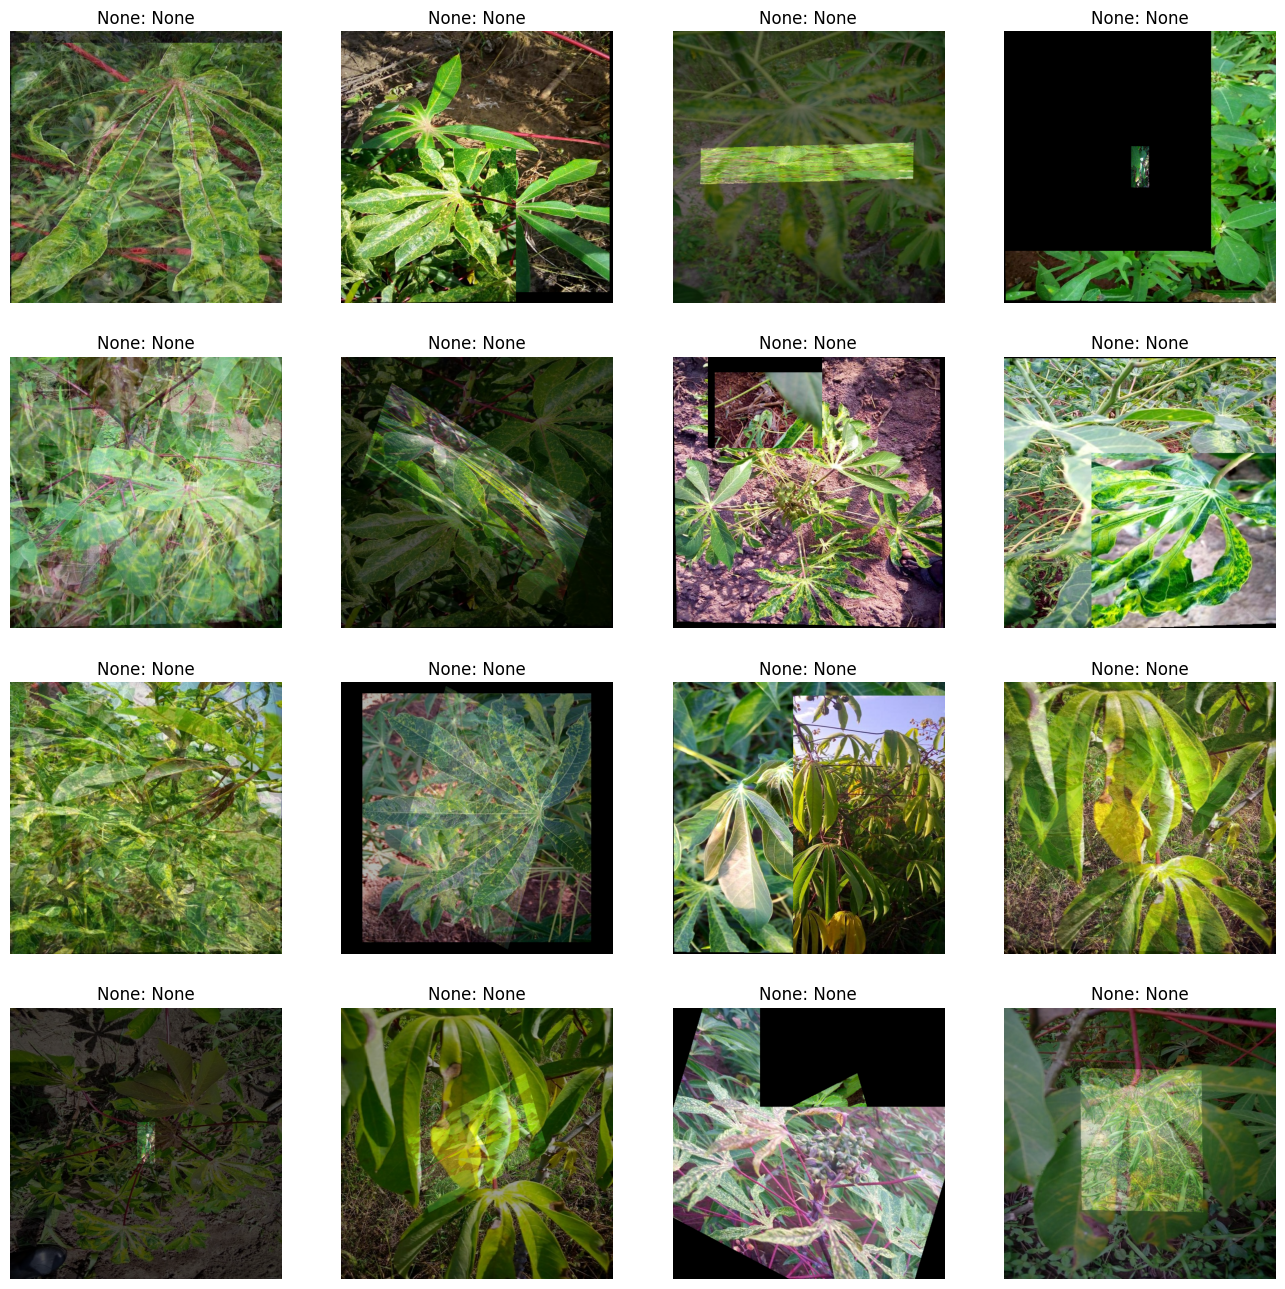

In [29]:
images, labels = next(iter(ds_show))
display_batch_of_images(images[:16])

In [30]:
labels[:16]

<tf.Tensor: shape=(16, 5), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , 0.6121862 , 0.3878138 ],
       [0.        , 0.        , 0.7744    , 0.        , 0.2256    ],
       [0.        , 0.        , 0.57425433, 0.        , 0.42574567],
       [0.7773361 , 0.22266388, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.39192462, 0.6080754 , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.09433055, 0.90566945],
       [0.7587856 , 0.        , 0.        , 0.2412144 , 0.        ],
       [0.7040828 , 0.        , 0.        , 0.2959172 , 0.        ],
       [0.6040951 , 0.3959049 , 0.        , 0.        

In [31]:
def save_results(final_loss, results, name):
    with open(name, "w") as f:
        for i in range(len(final_loss)):
            f.write(f"Fold {i} : {round(final_loss[i], 4)} \n")
        f.write(f"Loss CV : {results}")

# Model

In [36]:
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, ds_val, targets, save_name):
        self.y = targets
        self.x = ds_val
        self.best_score = 0.
        self.save_name = save_name
    def on_epoch_end(self, epoch, logs=None):

        preds = self.model.predict(self.x).astype(np.float32)
        print("compute metrics :")
        acc = accuracy_score(self.y, np.argmax(preds, axis=-1))
        loss = tf.keras.metrics.SparseCategoricalCrossentropy()(self.y, preds).numpy()
        logs["val_categorical_accuracy"] = acc
        logs["val_loss"] = loss
        keys = list(logs.keys())


        print("val_loss: {0} -- val_categorical_accuracy: {1} -- samples : {2}".format(round(loss,3), round(acc,3 ), len(preds) ))

        if self.best_score < acc:
          try:
            os.remove(self.save_name)
          except:
            print("checkpoint not removed")
          self.model.save_weights(self.save_name, overwrite=True)
          print(f"\n model saved, improvement from {self.best_score} to {acc}\n")
          self.best_score = acc

In [37]:
def compile_new_model(cfg, name, with_sgd=False):
    with strategy.scope():
        class CategoricalCrossentropyTeacherFreeLoss(tf.keras.losses.Loss):

          def __init__(self,
                    from_logits=False,
                    label_smoothing=0, alpha=0.5, normalize_teacher=False, **kwargs):
              super(CategoricalCrossentropyTeacherFreeLoss, self).__init__()
              self.from_logits=from_logits
              self.label_smoothing=label_smoothing
              self.loss_student = tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing, reduction=tf.keras.losses.Reduction.NONE)
              self.loss_teacher = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
              self.alpha = alpha
              self.normalize_teacher = normalize_teacher


          def __call__(self, y_true, y_pred, **kwargs):
              loss_value = self.loss_student(y_true, y_pred)
              smooth = 0.2/cfg.num_class
              teacher_target = tf.abs(y_true-smooth)

              loss_value2 = self.loss_teacher(teacher_target, y_pred)
              #print(tf.reduce_mean(loss_value), tf.reduce_mean(loss_value2))
              #print(loss_value.shape, loss_value2.shape)
              return self.alpha * tf.reduce_mean(loss_value) + (1-self.alpha) * tf.reduce_mean(loss_value2)
        def TeacherFreeLoss(y_true, y_pred):
          smoothing = 0.1
          alpha = 0.5
          teacher = tf.abs(y_true - smoothing)
          teacher_loss = tf.keras.losses.MeanSquaredError()(teacher, y_pred)
          return tf.keras.losses.CategoricalCrossentropy(label_smoothing = cfg.smoothing)(y_true, y_pred) * alpha + (1-alpha) *  teacher_loss

        #model = load_focalnet(cfg.model_name, num_classes=cfg.num_class, act_output= "softmax", img_size= cfg.resize)
        inputs = Input((*cfg.resize, 3))
        backbone =  load_focalnet(cfg.model_name, num_classes=0,  img_size= cfg.resize)
        x = BatchNormalization()(inputs)
        x = backbone(x)
        #x =  Dropout(0.5)(x)
        x = Dense(cfg.num_class, activation="softmax")(x)
        model = Model(inputs, outputs=x)
        #  CategoricalCrossentropyTeacherFreeLoss(label_smoothing = cfg.smoothing, alpha=0.5) #
        losses =tf.keras.losses.CategoricalCrossentropy(label_smoothing = cfg.smoothing) #CategoricalCrossentropyCustom(label_smoothing = cfg['smoothing'])#
        opt = tf.keras.optimizers.SGD(lr=1e-4) if with_sgd else tf.keras.optimizers.Adam(learning_rate=1e-3)

        model.compile(
            optimizer = opt ,
            loss      =  losses,
            metrics   = tf.keras.metrics.CategoricalAccuracy()
        )

    return model

In [38]:
with strategy.scope():
        class CrossentropyTeacherFreeLoss(tf.keras.losses.Loss):

          def __init__(self,
                    from_logits=False,
                    label_smoothing=0, teacher_smoothing=0.15, alpha=0.5, normalize_teacher=False, num_classes=None, **kwargs):
              super(CrossentropyTeacherFreeLoss, self).__init__()
              self.from_logits=from_logits
              self.label_smoothing=label_smoothing
              self.teacher_smoothing = teacher_smoothing
              self.loss_student = tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing, reduction=tf.keras.losses.Reduction.NONE)
              self.loss_teacher = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
              self.alpha = alpha
              self.normalize_teacher = normalize_teacher
              self.num_classes = num_classes


          def __call__(self, y_true, y_pred, **kwargs):
              loss_value = self.loss_student(y_true, y_pred)
              smooth = self.teacher_smoothing/self.num_classes
              teacher_target = tf.abs(tf.cast(y_true, tf.float32) -smooth)

              loss_value2 = self.loss_teacher(teacher_target, y_pred)
              #print(tf.reduce_mean(loss_value), tf.reduce_mean(loss_value2))
              #print(loss_value.shape, loss_value2.shape)
              return self.alpha * tf.reduce_mean(loss_value) + (1-self.alpha) * tf.reduce_mean(loss_value2)

In [39]:
def compile_new_model_eff(cfg, name, with_sgd=False):
    with strategy.scope():

        inputs = Input((*cfg.resize, 3))
        x = BatchNormalization()(x)
        backbone =  tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, pooling="avg", weights='imagenet')
        x = backbone(x)
        x =  Dropout(0.5)(x)
        x = Dense(cfg.num_class, activation="softmax")(x)
        model = Model(inputs, outputs=x)

        losses = tf.keras.losses.CategoricalCrossentropy(label_smoothing = cfg.smoothing) #CategoricalCrossentropyCustom(label_smoothing = cfg['smoothing'])#
        opt = tf.keras.optimizers.SGD(lr=1e-2) if with_sgd else tf.keras.optimizers.Adam(learning_rate=1e-4)

        model.compile(
            optimizer = opt ,
            loss      =  losses,
            metrics   = tf.keras.metrics.CategoricalAccuracy()
        )

    return model

def compile_new_model_convnext(cfg, name, with_sgd=False):
    with strategy.scope():
        backbone = create_model(cfg.model_name, pretrained=True)
        inputs = Input((*cfg.resize, 3))
        x = BatchNormalization()(inputs)
        x = backbone(x)
        x = GlobalAveragePooling2D()(x)
        x =  Dropout(0.25)(x)
        x = Dense(cfg.num_class, activation="softmax")(x)
        model = Model(inputs, outputs=x)

        #losses = tf.keras.losses.CategoricalCrossentropy(label_smoothing = cfg.smoothing) #CategoricalCrossentropyCustom(label_smoothing = cfg['smoothing'])#
        losses = CrossentropyTeacherFreeLoss(label_smoothing=cfg.smoothing, teacher_smoothing=0.1, alpha=0.5, normalize_teacher=False, num_classes=cfg.num_class)
        opt = tf.keras.optimizers.SGD(lr=1e-2) if with_sgd else tf.keras.optimizers.Adam(learning_rate=1e-4)

        model.compile(
            optimizer = opt ,
            loss      =  losses,
            metrics   = tf.keras.metrics.CategoricalAccuracy()
        )

    return model



# ConvNext

In [40]:
from tfimm.architectures.convnext import ConvNeXtConfig, ConvNeXtStage, _weight_initializers
from collections import OrderedDict
from typing import List, Tuple, Optional
from tfimm.layers import MLP, ConvMLP, DropPath, norm_layer_factory
from tfimm.models import ModelConfig, keras_serializable, register_model
from tfimm.utils import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
class ConvNeXt(tf.keras.Model):
    """
    Class implementing a ConvNeXt network.
    Paper: `A ConvNet for the 2020s <https://arxiv.org/pdf/2201.03545.pdf>`_.
    Parameters:
        cfg: Configuration class for the model.
        **kwargs: Arguments are passed to ``tf.keras.Model``.
    """

    cfg_class = ConvNeXtConfig

    def __init__(self, cfg: ConvNeXtConfig, **kwargs):
        kwargs["name"] = kwargs.get("name", cfg.name)
        super().__init__(**kwargs)
        self.cfg = cfg
        norm_layer = norm_layer_factory(cfg.norm_layer)
        kernel_initializer, bias_initializer = _weight_initializers()

        self.stem_conv = tf.keras.layers.Conv2D(
            filters=cfg.embed_dim[0],
            kernel_size=cfg.patch_size,
            strides=cfg.patch_size,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            name="stem/0",
        )
        self.stem_norm = norm_layer(name="stem/1")

        # Stochastic depth
        dpr = np.linspace(0.0, cfg.drop_path_rate, sum(cfg.nb_blocks))
        dpr = np.split(dpr, np.cumsum(cfg.nb_blocks))

        self.stages = []
        nb_stages = len(cfg.nb_blocks)
        for j in range(nb_stages):
            self.stages.append(
                ConvNeXtStage(
                    stride=2 if j > 0 else 1,
                    embed_dim=cfg.embed_dim[j],
                    nb_blocks=cfg.nb_blocks[j],
                    mlp_ratio=cfg.mlp_ratio,
                    conv_mlp_block=cfg.conv_mlp_block,
                    drop_rate=cfg.drop_rate,
                    drop_path_rate=dpr[j],
                    norm_layer=cfg.norm_layer,
                    act_layer=cfg.act_layer,
                    init_scale=cfg.init_scale,
                    name=f"stages/{j}",
                )
            )


    @property
    def dummy_inputs(self) -> tf.Tensor:
        """Returns a tensor of the correct shape for inference."""
        return tf.zeros((1, *self.cfg.input_size, self.cfg.in_channels))

    @property
    def feature_names(self) -> List[str]:
        """
        Names of features, returned when calling ``call`` with ``return_features=True``.
        """
        _, features = self(self.dummy_inputs, return_features=True)
        return list(features.keys())

    def forward_features(
        self, x, training: bool = False, return_features: bool = False
    ):
        """
        Forward pass through model, excluding the classifier layer. This function is
        useful if the model is used as input for downstream tasks such as object
        detection.
        Arguments:
             x: Input to model
             training: Training or inference phase?
             return_features: If ``True``, we return not only the model output, but a
                dictionary with intermediate features.
        Returns:
            If ``return_features=True``, we return a tuple ``(y, features)``, where
            ``y`` is the model output and ``features`` is a dictionary with
            intermediate features.
            If ``return_features=False``, we return only ``y``.
        """
        features = OrderedDict()
        x = self.stem_conv(x)
        x = self.stem_norm(x, training=training)
        features["stem"] = x

        for stage_idx, stage in enumerate(self.stages):
            x = stage(x, training=training, return_features=return_features)
            if return_features:
                x, stage_features = x
                for key, val in stage_features.items():
                    features[f"stage_{stage_idx}/{key}"] = val
        features["conv_features"] = x

        return (x, features) if return_features else x

    def call(self, x, training: bool = False, return_features: bool = False):
        """
        Forward pass through the full model.
        Arguments:
             x: Input to model
             training: Training or inference phase?
             return_features: If ``True``, we return not only the model output, but a
                dictionary with intermediate features.
        Returns:
            If ``return_features=True``, we return a tuple ``(y, features)``, where
            ``y`` is the model output and ``features`` is a dictionary with
            intermediate features.
            If ``return_features=False``, we return only ``y``.
        """
        features = OrderedDict()
        x = self.forward_features(x, training, return_features)
        if return_features:
            x, features = x
        return (x, features) if return_features else x

In [41]:
import logging
import re
from copy import deepcopy
from typing import Callable, List, Optional

import tensorflow as tf
from tensorflow.python.keras import backend as K

from tfimm.models.registry import is_model, model_class, model_config
from tfimm.utils import cached_model_path, load_pth_url_weights, load_timm_weights
def create_model(
    model_name: str,
    pretrained: bool = False,
    model_path: str = "",
    *,
    in_channels: Optional[int] = None,
    nb_classes: Optional[int] = None,
    **kwargs,
) -> tf.keras.Model:
    """
    Creates a model.
    Args:
        model_name: Name of model to instantiate
        pretrained: If ``True``, load pretrained weights as specified by the ``url``
            field in config. We will check the cache first and download weights only
            if they cannot be found in the cache.
            If ``url`` is ``[timm]``, the weights will be downloaded from ``timm`` and
            converted to TensorFlow. Requires ``timm`` and ``torch`` to be installed.
            If ``url`` starts with ``[pytorch]``, the weights are in PyTorch format
            and ``torch`` needs to be installed to convert them.
        model_path: Path of model weights to load after model is initialized. This takes
            over ``pretrained``.
        in_channels: Number of input channels for model. If ``None``, use default
            provided by model.
        nb_classes: Number of classes for classifier. If set to 0, no classifier is
            used and last layer is pooling layer. If ``None``, use default provided by
            model.
        **kwargs: Other kwargs are model specific.
    Returns:
        The created model.
    """
    if not is_model(model_name):
        raise RuntimeError(f"Unknown model {model_name}.")

    cls = model_class(model_name) if "convnext" not in model_name else ConvNeXt

    convnext_register = {
          'convnext_tiny_in22ft1k': 'convnext_tiny.fb_in22k_ft_in1k',
          'convnext_small_in22ft1k': 'convnext_small.fb_in22k_ft_in1k',
          'convnext_base_in22ft1k': 'convnext_base.fb_in22k_ft_in1k',
          'convnext_large_in22ft1k': 'convnext_large.fb_in22k_ft_in1k',
          'convnext_xlarge_in22ft1k': 'convnext_xlarge.fb_in22k_ft_in1k',
          'convnext_tiny_384_in22ft1k': 'convnext_tiny.fb_in22k_ft_in1k_384',
          'convnext_small_384_in22ft1k': 'convnext_small.fb_in22k_ft_in1k_384',
          'convnext_base_384_in22ft1k': 'convnext_base.fb_in22k_ft_in1k_384',
          'convnext_large_384_in22ft1k': 'convnext_large.fb_in22k_ft_in1k_384',
          'convnext_xlarge_384_in22ft1k': 'convnext_xlarge.fb_in22k_ft_in1k_384',
          'convnext_tiny_in22k': 'convnext_tiny.fb_in22k',
          'convnext_small_in22k': 'convnext_small.fb_in22k',
          'convnext_base_in22k': 'convnext_base.fb_in22k',
          'convnext_large_in22k': 'convnext_large.fb_in22k',
          'convnext_xlarge_in22k': 'convnext_xlarge.fb_in22k',
      }
    cfg = model_config(model_name)
    print(cls)
    if model_path:
        loaded_model = tf.keras.models.load_model(model_path, compile=False)
    elif pretrained:
        # First try loading model from cache

        model_path = cached_model_path(model_name)
        if model_path:
            loaded_model = tf.keras.models.load_model(model_path)
        elif cfg.url.startswith("[timm]"):
            loaded_model = cls(cfg)
            loaded_model(loaded_model.dummy_inputs)
            # Url can be "[timm]timm_model_name" or "[timm]" in which case we default
            # to model_name.
            timm_model_name = cfg.url[len("[timm]") :] or model_name
            if "convnext" in model_name:
              timm_model_name = convnext_register[timm_model_name]
            print(timm_model_name)
            load_timm_weights(loaded_model, timm_model_name)
        elif cfg.url.startswith("[pytorch]"):
            url = cfg.url[len("[pytorch]") :]
            loaded_model = cls(cfg)
            loaded_model(loaded_model.dummy_inputs)
            load_pth_url_weights(loaded_model, url)
        else:
            raise NotImplementedError(
                "Model not found in cache. Download of weights only implemented for "
                "PyTorch models."
            )
    else:
        loaded_model = None

    # Update config with kwargs
    cfg = deepcopy(cfg)
    for key, value in kwargs.items():
        if hasattr(cfg, key):
            setattr(cfg, key, value)
        else:
            logging.warning(
                f"Config for {model_name} does not have field `{key}`. Ignoring field."
            )
    if in_channels is not None:
        setattr(cfg, "in_channels", in_channels)
    if nb_classes is not None:
        setattr(cfg, "nb_classes", nb_classes)

    # `keras.Model` kwargs need separate treatment. For now we support only `name`.
    model_kwargs = {}
    if "name" in kwargs:
        model_kwargs["name"] = kwargs["name"]

    # If we have loaded a model and the model has the correct config, then we are done.
    if loaded_model is not None and loaded_model.cfg == cfg:
        return loaded_model

    # Otherwise, we build a new model and transfer the weights to it. This is because
    # some parameter changes (in_channels and nb_classes) require changing the shape of
    # some weights or dropping of others. And there might be non-trivial interactions
    # between various parameters, e.g., global_pool can be None only if nb_classes is 0.
    model = cls(cfg, **model_kwargs)
    model(model.dummy_inputs)  # Call model to build layers

    # Now we need to transfer weights from loaded_model to model
    if loaded_model is not None:
        transfer_weights(loaded_model, model)

    return model

# Training

In [43]:
model = compile_new_model_convnext(cfg, cfg.model_name, with_sgd=False)

<class '__main__.ConvNeXt'>
convnext_large.fb_in22k


model.safetensors:   0%|          | 0.00/919M [00:00<?, ?B/s]

In [45]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 600, 600, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 600, 600, 3)      12        
 ormalization)                                                   
                                                                 
 convnext_large_in22k (ConvN  (None, 18, 18, 1536)     196227264 
 eXt)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_72 (Dropout)        (None, 1536)              0         
                                                             

In [42]:
EVAL_ONLY= False

In [ ]:
oof_val_all = []
oof_target_all = []
scores = []
skf = KFold(n_splits=cfg.kfold,shuffle=True,random_state=cfg.seed)
oof_val = []
oof_target = []
oof_names = []
oof_folds = []
b_s = []
for fold,(train_idx, val_idx) in enumerate(skf.split(range(len(FILENAMES)))):
    print(f"## FOLD: {fold}")
    #load_name = cfg.folder_load"] + cfg['name'][num_model]+'-fold-%i.h5'%fold
    K.clear_session()
    if DEVICE=='TPU':
        if tpu:
            tf.tpu.experimental.initialize_tpu_system(tpu)

    # CREATE TRAIN AND VALIDATION SUBSETS

    filenames_tr = [FILENAMES[i] for i in train_idx] #  + EXT # add external dataset if needed
    filenames_val = [FILENAMES[i] for i in val_idx]
    print(f"Training examples : {count_data_items(filenames_tr)} // Validation examples : {count_data_items(filenames_val)} // {val_idx}")
    ds_train = get_training_dataset(filenames_tr, mixup=cfg.mixup, cutmix=cfg.cutmix)
    ds_val = get_validation_dataset(filenames_val)
    ds_val2 = get_validation_dataset(filenames_val, labels_only=True)
    print("Creating model")
    save_name = cfg.folder + cfg.model_name+'-fold-%i.h5'%fold # cfg['name'][num_model]+'-fold-%i.h5'%fold #
    # BUILD MODEL

    with strategy.scope():
        model = compile_new_model_convnext(cfg, cfg.model_name, with_sgd=False)


        # callbacks
        checkpoint = tf.keras.callbacks.ModelCheckpoint(save_name, monitor='val_categorical_accuracy', verbose=1, save_best_only=True,
            save_weights_only=True, mode='max', save_freq='epoch')
        lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=5, verbose=1, mode='max',min_lr=5e-6)
        print("Creating callback")
        targets_labels = np.concatenate([label.numpy().argmax(-1) for label, name in ds_val2])
        targets_names = np.concatenate([name for label, name in ds_val2])
        oof_names.append(targets_names)
        oof_folds.append([fold] * len(targets_names))
        metric = MetricsCallback(ds_val, targets_labels, save_name)
        metric._supports_tf_logs = True
        callbacks = [metric,  lr_reducer]

    # TRAIN
    print("load ckpt")
    #model.load_weights("drive/My Drive/Cassava/convnext_xlarge_in22k-cutmix-noext-convnext_xlarge_in22k-fold-0.h5")
    print('Training...')

    if not EVAL_ONLY:
      history = model.fit(ds_train,epochs= cfg.epochs, callbacks = callbacks,
        steps_per_epoch=count_data_items(filenames_tr)/BATCH_SIZE//REPLICAS,
          verbose=1) # validation_data=ds_val,





    b_s.append(metric.best_score)
    print('Loading best model...', save_name)
    model.load_weights(save_name)

    # prediction on val

    preds_val = model.predict(ds_val).astype(np.float32)
    oof_val.append(preds_val)

    oof_target.append( targets_labels)
    print("samples ! : ", len(targets_labels) )
    scores.append(accuracy_score(targets_labels, np.argmax(preds_val, axis=-1)))
    print("Validation final :", scores[-1])
    break
oof_target = np.concatenate(oof_target)
oof_val = np.concatenate(oof_val)
oof_names = np.concatenate(oof_names)



## FOLD: 0


Training examples : 17118 // Validation examples : 4279 // [1 8]
Creating model
<class '__main__.ConvNeXt'>
convnext_large.fb_in22k


Creating callback


Exception ignored in: <function Executor.__del__ at 0x7e6f9c505b40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7e6f9c505b40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


load ckpt
Training...
Epoch 1/150
 6/33 [====>.........................] - ETA: 34s - loss: 1.6512 - categorical_accuracy: 0.4010

67/67 [==============================] - 62s 439ms/step
compute metrics :
val_loss: 0.9829999804496765 -- val_categorical_accuracy: 0.643 -- samples : 4279
checkpoint not removed

 model saved, improvement from 0.0 to 0.6433746202383734

33/33 [==============================] - 295s 4s/step - loss: 1.0565 - categorical_accuracy: 0.4905 - val_categorical_accuracy: 0.6434 - val_loss: 0.9831 - lr: 1.0000e-04
Epoch 2/150
67/67 [==============================] - 31s 439ms/step
compute metrics :
val_loss: 0.7519999742507935 -- val_categorical_accuracy: 0.702 -- samples : 4279

 model saved, improvement from 0.6433746202383734 to 0.702266884786165

33/33 [==============================] - 87s 3s/step - loss: 0.6218 - categorical_accuracy: 0.6188 - val_categorical_accuracy: 0.7023 - val_loss: 0.7520 - lr: 1.0000e-04
Epoch 3/150
67/67 [==============================] - 31s 439ms/step
compute metrics :
val_loss: 0.6869999766349792 -- val_categorical_accuracy: 0.743 -- samples : 4279

 model save

In [ ]:
#tfimm.list_models()

In [ ]:
#import timm
#timm.list_models()